# **Comprehensive NLP Analysis of Global News Headlines (2019-Present)**

This document presents a **thorough Natural Language Processing (NLP) analysis** of global news headlines spanning from **2019 to the present**. The analysis demonstrates proficiency in fundamental NLP techniques, preprocessing steps, and insightful visualizations that extract meaningful patterns from textual data.

---

## **Table of Contents**

1. [**Introduction**](#introduction)
2. [**Data Exploration**](#data-exploration)
3. [**Data Preprocessing**](#data-preprocessing)
   - [Text Normalization](#text-normalization)
   - [Tokenization](#tokenization)
   - [Stop Words Removal](#stop-words-removal)
   - [Token Unification and Renormalizing Entities](#token-unification)
   - [Part-of-Speech Tagging](#part-of-speech-tagging)
   - [Lemmatization](#lemmatization)
   - [Named Entity Recognition](#named-entity-recognition)
4. [**Feature Extraction**](#feature-extraction)
   - [Bag of Words](#bag-of-words)
   - [TF-IDF Vectorization](#tf-idf-vectorization)
   - [Word Embeddings](#word-embeddings)
5. [**Sentiment Analysis**](#sentiment-analysis)
   - [Monthly Sentiment Trends](#monthly-sentiment-trends)
   - [Year-over-Year Sentiment Comparison](#year-over-year-sentiment-comparison)
6. [**Topic Modeling**](#topic-modeling)
   - [Latent Dirichlet Allocation](#latent-dirichlet-allocation)
   - [Topic Evolution Over Time](#topic-evolution-over-time)
7. [**Entity Analysis**](#entity-analysis)
   - [Most Mentioned Entities](#most-mentioned-entities)
   - [Entity Co-occurrence Networks](#entity-co-occurrence-networks)
8. [**Time Series Analysis**](#time-series-analysis)
   - [Headline Complexity Over Time](#headline-complexity-over-time)
   - [Topic Seasonality](#topic-seasonality)
9. [**Conclusion**](#conclusion)

---

## **Introduction**

This analysis explores a rich dataset of **news headlines** from **2019 to 2023**, covering **25 of the world's most influential news headlines**. The dataset is structured with **dates** in the first column followed by 25 headlines from each source. By applying various **NLP techniques**, we aim to uncover patterns, trends, and insights that reveal how global news discourse has evolved over this significant period, from sentimental analysis of each day and year to reoccuring patterns of entities and how their sentiment on the media has changed over the years, or as i like to call it, the sentimental derivative. 

---

## **Data Exploration**

Let's begin by loading the dataset and exploring its basic structure:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the dataset
news_df = pd.read_csv('datasets/WorldNewsData.csv')

# Display basic information
print(f"Dataset shape: {news_df.shape}")



# Check the first few rows


# Convert Date column to datetime (note capital "D")
# Since the date format is "May 01, 2018", we need to parse it correctly
news_df['Date'] = pd.to_datetime(news_df['Date'], format="%b %d, %Y")

# Display the date range
print(f"\nTime period: {news_df['Date'].min()} to {news_df['Date'].max()}")

# Create a year-month column for temporal analysis
news_df['year_month'] = news_df['Date'].dt.to_period('M')

# Create a column for the year
news_df['year'] = news_df['Date'].dt.year

# Create a column for the month
news_df['month'] = news_df['Date'].dt.month

# Sample a few rows
print("\nSample data:")
news_df.head()

Dataset shape: (1859, 26)

Time period: 2018-05-01 00:00:00 to 2023-04-30 00:00:00

Sample data:


,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,year_month,year,month
0,2018-05-01,"North Korea to open its sky, South Korean medi...",The Mueller probe ain't ending anytime soon,BRAND NEW: 2018 – Renault Alpine A110 – Start-...,The story of the Midwestern innocent let loose...,Mattis tempers optimistic outlook on Afghanist...,Facebook is taking on Tinder with new dating f...,OECD chief says Greece deserves debt relief af...,Facebook to launch dating service,U.N. could help Myanmar gather evidence of cri...,...,My Email Newsletter of Curated Marketing Content,Mueller asks for 2 more months before Flynn se...,Mueller asks for 2 more months before Flynn se...,Canada to tack a carbon price of at least 11 c...,Kanye West: 'The class war is one of the reaso...,Michael Stewart/WireImage Kylie Jenner simply ...,For first time health ministry will regulate d...,2018-05,2018,5
1,2018-05-02,'What have they got to fear? ' Trump threatens...,"Best Garage Heater Reviews incuding electric, ...",Apple just fueled everyone's biggest fear abou...,Google accused of using GDPR to impose unfair ...,Man died accidentally after climbing behind wo...,When the coveted Palme d’Or trophy is awarded ...,"""Borders are Illegal?"" Tucker Carlson Vs Dumb ...","Mark Zuckerberg says it will take 3 years to ""...",The 8 Best Cooling Pillows You Can Buy,...,House Republicans nominate Donald Trump for No...,UK's May faces local election losses as key Br...,Whynter ICM-15LS Ice Cream Maker Review,"Abbas says Jews’ behavior, not anti-Semitism, ...",House Republicans nominate Trump for Nobel Pea...,"Tyson Foods the largest U.S. meat processor, h...",Questions linger about how Melania Trump score...,2018-05,2018,5
2,2018-05-03,Hollywood isn’t simply churning out crummy rem...,Iran's foreign minister: US has ‘consistently ...,Rihanna covers the June 2018 problem of Vogue ...,U.S. soldiers are secretly fighting Saudi Arab...,Canadian MP Bob Saroya took trip to China paid...,2017 Best Black Friday and Cyber Monday Mattre...,"NBC, ABC Say Trump Lawyer Michael Cohen Was No...",South Korean janitor may keep gold bars found ...,Last chance: UN warns Cambodia over failing de...,...,Marketing’s Customer Obsession Imperative | C3...,Ex-Trump aide Michael Caputo warns: Mueller Ru...,11-Year-Old Girl With Autism Wouldn’t Talk In ...,Richard Corkery/NY Each day Information throug...,What Makes the Brand Stand Out?,UK drones in Syria using controversial 'vacuum...,"High fruit diet could help women conceive, stu...",2018-05,2018,5
3,2018-05-04,Donald Trump says London hospital is 'like a w...,German seat on UN Security Council likely as I...,Gang Used Drone Swarm To Thwart FBI Hostage Raid,How Many Carbs Should You Eat Per Day To Lose ...,Russian Troll Farm Goes After Mueller’s Files,Israeli soldiers singing in Persian for Irania...,Labor Day 2017 Sales on Memory Foam Mattresses...,"How a Chinese city turned all its 16,000 buses...",Jamie Acourt arrested in Spain over suspected ...,...,How to Increase Sales by Encouraging Mobile Sp...,China’s schooling Trump on the art of the delay,Abi Ofarim ist tot,The 8 Best Snow Boots For Women,Kerry quietly seeking to salvage Iran deal he ...,Trump's Syria aid freeze hits 'White Helmets' ...,US slams Turkey over population transfers in A...,2018-05,2018,5
4,2018-05-05,Missing teen’s mom implores Canada to take not...,William and Kate release new pictures of Princ...,MEGHANS BROTHER SENDS PRINCE HARRY A SECRET LE...,Australia: Free whooping cough vaccine will be...,Shock and Thaw—Alaskan Sea Ice Just Took a Ste...,Giuliani: Trump is 'committed to' regime chang...,Pakistan: Polio eradication teams will visit d...,"Aides to Donald Trump, the US president, hired...",Donald Trump’s NRA speech causes anger in U.K....,...,Revealed: Trump team hired spy firm for ‘dirty...,A Simple Way to Improve a Billion Lives: Eyegl...,Dutch cop requests removal of Holocaust memori...,Montreal couple agree to submit

## **Data Preprocessing**

 There are some duplicate months in the original data, (like October 2020) Lets start by removing the duplicates and clearing the dataset. Next, let's create a function to combine all headlines for each day into a single text corpus, and a list that contains the headlines separately, so we can analyze both on per day basis and per headline. This distinction will be useful later on.

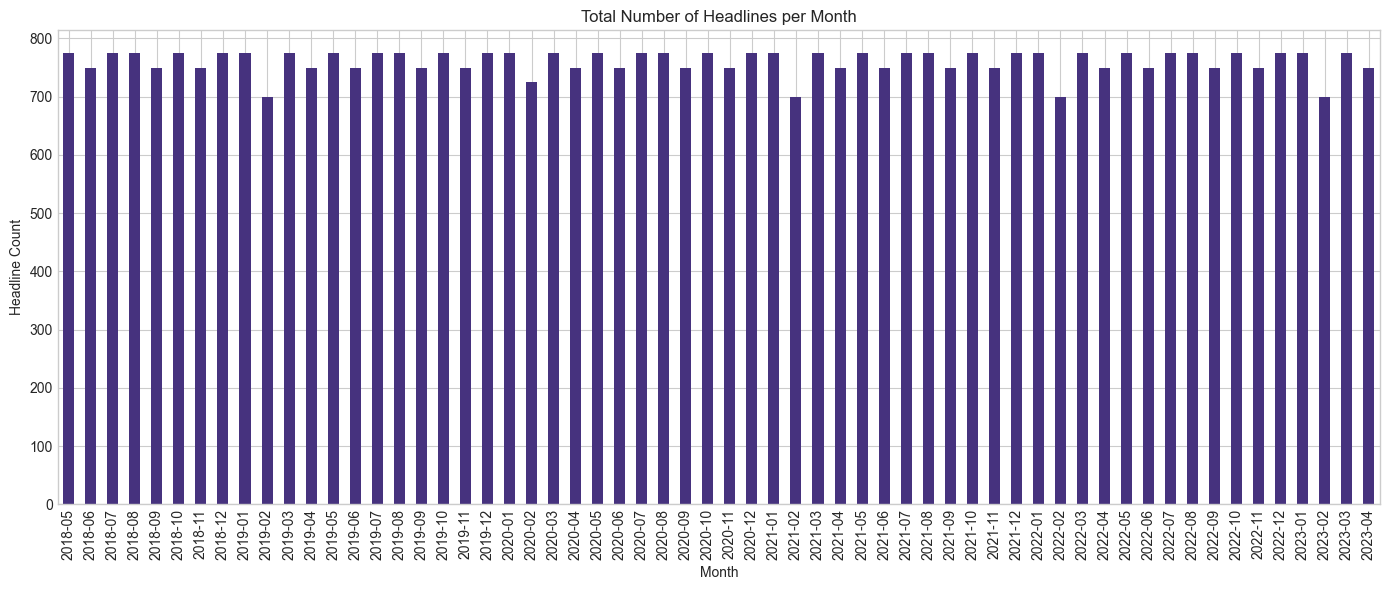

In [2]:
# ensuring 'Date' is in datetime format
news_df['Date'] = pd.to_datetime(news_df['Date'])

# drop duplicates
news_df = news_df.drop_duplicates(subset='Date', keep='first')

def combine_headlines(row):
    # combine all headlines in a row into a single string for easy day based tokenization later
    headlines = []
    # start from column 'Top1' through 'Top25'
    for col in news_df.columns[1:26]:  # Skip the Date column, include only Top1-Top25
        if pd.notna(row[col]):
            headlines.append(str(row[col]))
    return ' '.join(headlines)

# Apply the function to create a new column with combined headlines
news_df['combined_headlines'] = news_df.apply(combine_headlines, axis=1)

headlines_per_month = news_df.groupby(news_df['Date'].dt.to_period('M')).size() * 25

plt.figure(figsize=(14, 6))
headlines_per_month.plot(kind='bar')
plt.title('Total Number of Headlines per Month')
plt.xlabel('Month')
plt.ylabel('Headline Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a new column that stores the list of non-null individual headlines (Top1–Top25)
def get_separate_headlines(row):
    """Return a list of non-empty individual headlines"""
    return [str(row[col]) for col in news_df.columns[1:26] if pd.notna(row[col])]

news_df['separate_headlines'] = news_df.apply(get_separate_headlines, axis=1)

# Count number of headlines (not assuming all 25 filled)
news_df['headline_count'] = news_df['separate_headlines'].apply(len)

# Group by month and sum all actual headlines
separate_headlines_per_month = news_df.groupby(news_df['Date'].dt.to_period('M'))['headline_count'].sum()


# **Text Normalization**

Now our data looks clear and no unusual spikes showing duplicate data. Before diving into the deeper depths of data processing, we need to normalize our dataset. Normalization is like organizing a dataset, we need to remove symbols, lowercase everything, remove numbers, non-UNICODE letters, and some other things based on what we need, we might need to remove words like "in, and, out, of" (which are called stopwords) because they might skew the data by introducing unnecessary bias. We actually took our first step already by removing duplicates! We will do a general normalization here and might use more in depth techniques like lemmatization or stemming based on our needs. 

Next, lets start by defining a new function normalize_text() to do every normalization step we desire to the dataset and store it in a variable.

In [3]:
# !pip install spacy contractions

# python -m spacy download en_core_web_sm
import re
import string
import html
import contractions
import spacy
import pandas as pd

# Load spaCy model (blank English model to avoid over-processing)
nlp = spacy.blank("en")

def normalize_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
        
    # Step 1: Pre-replace acronyms with more comprehensive dict
    acronyms = {"U.N.": "UN", "U.S.": "US", "E.U.": "EU", "u.s.": "US", 
                "U.K.": "UK", "N.Y.": "NY", "L.A.": "LA"}
    for k, v in acronyms.items():
        text = text.replace(k, v)
    
    # Step 2: Expand contractions with error logging
    try:
        text = contractions.fix(text)
    except Exception as e:
        print(f"Contraction expansion error: {e} in text: {text[:50]}...")
    
    # Step 3: Lowercase
    text = text.lower()
    
    # Step 4: Remove possessive 's or 's (improved patterns)
    text = re.sub(r"\b(\w+)['']\s*s\b", r"\1", text)  # Handles standard possessives
    text = re.sub(r"\b(\w+s)['']\b", r"\1", text)     # Handles plural possessives
    
    # Step 5: Remove remaining apostrophes (shouldn't be needed, for edge cases)
    text = re.sub(r"(\w+)'(\w+)", r"\1\2", text)
    text = re.sub(r"(\w+)'", r"\1", text)
    
    # Step 6: Remove punctuation and smart quotes/dashes
    punct_chars = string.punctuation + "–—''""•"
    text = re.sub(f"[{re.escape(punct_chars)}]", "", text)
    
    # Step 7: HTML unescape and entity removal (combined)
    text = html.unescape(text)
    text = re.sub(r'&[a-zA-Z#0-9]+;', '', text)  # Remove any remaining entities
    
    # Step 8: Remove any non-English characters and emojis
    # Note: This will remove numbers as per original code
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Step 9: Remove any remaining single s (from cases like "60's")
    text = re.sub(r'\b[sS]\b', '', text)
    
    # Step 10: Collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.strip()

# Make sure the dataframe is properly filtered before processing
news_df = news_df[
    news_df['Date'].notna() & 
    news_df['combined_headlines'].notna() & 
    (news_df['combined_headlines'].str.strip() != '')
]

# Apply normalization
news_df['normalized_text'] = news_df['combined_headlines'].apply(normalize_text)

# This one is the headlines divided individually instead of a per-day basis of concatenation.
# As stated, this might be useful later on to track the sentimental derivative
# of specific entities. This line applies our normalize function to every h in lst,
# or specifically every headline in every row and column.
news_df['normalized_separate'] = news_df['separate_headlines'].apply(
    lambda lst: [normalize_text(h) for h in lst if h]  # Added check for empty headlines
)

# Display a sample of normalized text
print("Original headline:")
print(news_df['combined_headlines'].iloc[0][:400])
print("\nNormalized headline:")
print(news_df['normalized_text'].iloc[0][:400])
print("\nOriginal Separated headline:")
print(news_df['separate_headlines'].iloc[0][:10])
print("\nNormalized Separated headline:")
print(news_df['normalized_separate'].iloc[0][:10])

Contraction expansion error: string index out of range in text: Wi-Fi Bağlantısının Durumunu Öğrenmek İçin Gelişti...
Original headline:
North Korea to open its sky, South Korean media reports. The Mueller probe ain't ending anytime soon BRAND NEW: 2018 – Renault Alpine A110 – Start-UP &amp; Loud Sound! The story of the Midwestern innocent let loose in the big city has been a trope in successful comedies from “Tales of the City” (1993) to “Girls” (2012). “Sweetbitter,” a new, six-episode series on Starz, takes another naif, doe-eye

Normalized headline:
north korea to open its sky south korean media reports the mueller probe are not ending anytime soon brand new renault alpine a startup amp loud sound the story of the midwestern innocent let loose in the big city has been a trope in successful comedies from tales of the city to girls sweetbitter a new sixepisode series on starz takes another naif doeeyed tess ella purnell and sets her loose in th

Original Separated headline:
['North K

We are getting there, Now its time for tokenization! 
# **Tokenization**

 Tokenization is the process of breaking text into individual words or tokens, I will use NLTK for this as spacy is not supported with python 3.13...

 We stored the normalized dataset in the variable "normalized_text", lets play around with it, and tokenize!

1. COMBINED TEXT TOKENS (first 40):
['north', 'korea', 'to', 'open', 'its', 'sky', 'south', 'korean', 'media', 'reports', 'the', 'mueller', 'probe', 'are', 'not', 'ending', 'anytime', 'soon', 'brand', 'new', 'renault', 'alpine', 'a', 'startup', 'amp', 'loud', 'sound', 'the', 'story', 'of', 'the', 'midwestern', 'innocent', 'let', 'loose', 'in', 'the', 'big', 'city', 'has']

2. SEPARATE HEADLINE TOKENS (first 5 headlines):
 Headline 1: ['north', 'korea', 'to', 'open', 'its', 'sky', 'south', 'korean', 'media', 'reports']
 Headline 2: ['the', 'mueller', 'probe', 'are', 'not', 'ending', 'anytime', 'soon']
 Headline 3: ['brand', 'new', 'renault', 'alpine', 'a', 'startup', 'amp', 'loud', 'sound']
 Headline 4: ['the', 'story', 'of', 'the', 'midwestern', 'innocent', 'let', 'loose', 'in', 'the', 'big', 'city', 'has', 'been', 'a', 'trope', 'in', 'successful', 'comedies', 'from', 'tales', 'of', 'the', 'city', 'to', 'girls', 'sweetbitter', 'a', 'new', 'sixepisode', 'series', 'on', 'starz', 'takes',

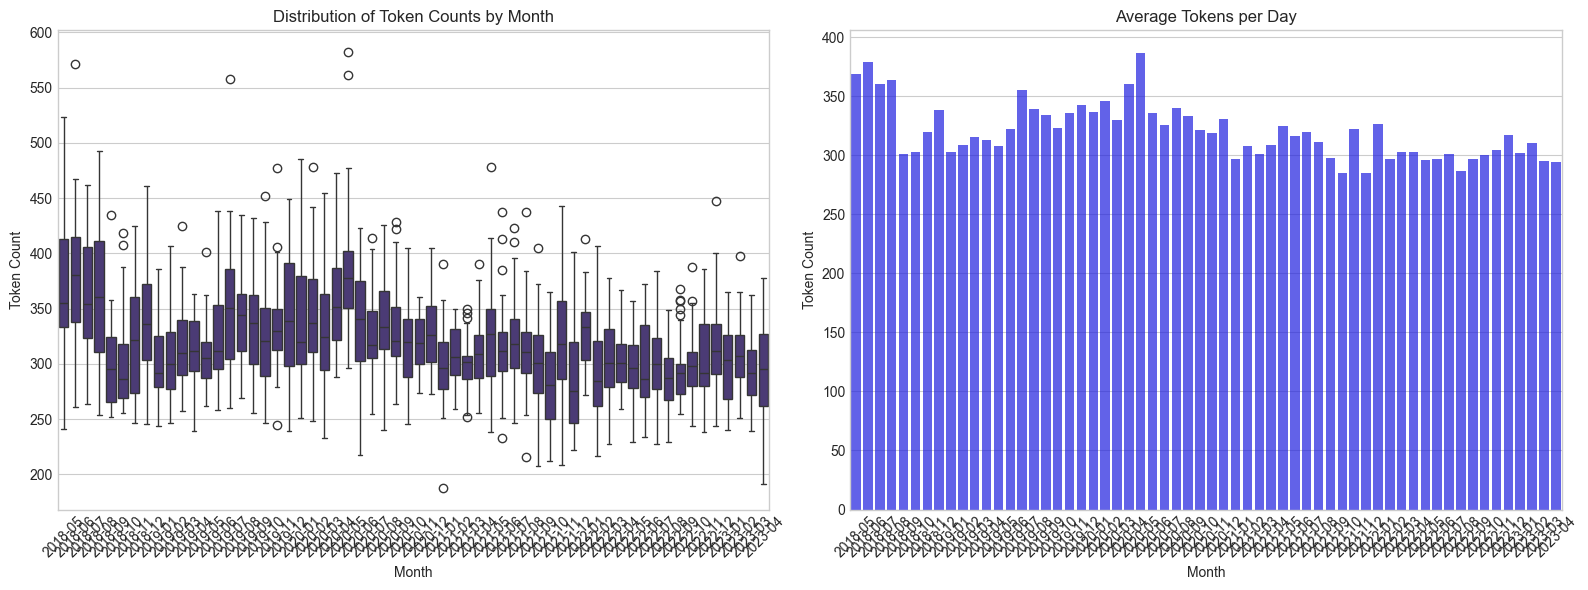

In [4]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize spaCy with custom tokenizer settings
nlp = spacy.blank("en")
tokenizer = nlp.tokenizer

# Add special cases to the tokenizer
special_cases = [{"ORTH": "covid19"}, {"ORTH": "covid-19"}]
for case in special_cases:
    nlp.tokenizer.add_special_case(case["ORTH"], [case])

def tokenize_text(text):
    """Splits text into individual words using spaCy's tokenizer with error handling"""
    if not text or not isinstance(text, str):
        return []
    try:
        tokens = tokenizer(text)
        # Return only non-empty tokens (optional: filter stop words)
        # Uncomment the stop words filter if needed
        # return [token.text for token in tokens if token.text.strip() and token.text.lower() not in STOP_WORDS]
        return [token.text for token in tokens if token.text.strip()]
    except Exception as e:
        print(f"Tokenization error: {e} in text: {text[:50]}...")
        return []

# Function for batch processing
def batch_tokenize(texts, batch_size=1000):
    """Process texts in batches for better performance"""
    # For simple tokenization, we can use the tokenizer directly
    return [tokenize_text(text) for text in texts]
    
    # For more complex NLP tasks, use spaCy's pipe:
    # results = []
    # for doc in nlp.pipe(texts, batch_size=batch_size):
    #     results.append([token.text for token in doc])
    # return results

# Apply tokenization to all texts
news_df['tokens'] = batch_tokenize(news_df['normalized_text'])

# For separate headlines - with error handling
def tokenize_headline_list(headline_list):
    if not headline_list:
        return []
    return [tokenize_text(h) for h in headline_list]

news_df['separate_tokens'] = news_df['normalized_separate'].apply(tokenize_headline_list)

# Display samples of all three token types
print("1. COMBINED TEXT TOKENS (first 40):")
print(news_df['tokens'].iloc[0][:40])

print("\n2. SEPARATE HEADLINE TOKENS (first 5 headlines):")
sample_headlines = news_df['separate_tokens'].iloc[0][:5] # Get first 5 headlines from first row
for i, headline_tokens in enumerate(sample_headlines):
    print(f" Headline {i+1}: {headline_tokens}")

# Token statistics with error handling
news_df['token_count'] = news_df['tokens'].apply(len)
news_df['avg_token_length'] = news_df['tokens'].apply(
    lambda x: np.mean([len(token) for token in x]) if x else 0
)

# separate_headlines total token count per day
news_df['separate_token_count'] = news_df['separate_tokens'].apply(
    lambda lst: sum(len(tokens) for tokens in lst) if lst else 0
)

# compute average word length with error handling
news_df['separate_avg_token_length'] = news_df['separate_tokens'].apply(
    lambda lst: np.mean([len(token) for tokens in lst for token in tokens]) if lst and any(tokens for tokens in lst) else 0
)

# each headline is treated like a sentence here
news_df['separate_sentence_count'] = news_df['normalized_separate'].apply(len)

# graph month column
news_df['Month'] = pd.to_datetime(news_df['Date']).dt.to_period('M').astype(str)

# Display statistics about all three token types
print("\nSTATISTICS SUMMARY:")
print(f"Combined text tokens: {news_df['token_count'].sum():,} total tokens")
print(f"Separate headlines: {news_df['separate_sentence_count'].sum():,} total headlines")
print(f"Separate headline tokens: {news_df['separate_token_count'].sum():,} total tokens")

# Visualization code
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Boxplot of token counts by month
sns.boxplot(x='Month', y='token_count', data=news_df, ax=axes[0])
axes[0].set_title('Distribution of Token Counts by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Token Count')
axes[0].tick_params(axis='x', rotation=45)

# Prepare data for grouped bar chart
news_df['separate_avg_tokens'] = news_df['separate_token_count'] / news_df['separate_sentence_count'].clip(lower=1)

monthly_stats = news_df.groupby('Month').agg({
    'token_count': 'mean',
    'separate_token_count': 'mean',
    'separate_avg_tokens': 'mean',
}).reset_index()

# Barplot of average token count by month
sns.barplot(x='Month', y='token_count', data=monthly_stats, ax=axes[1], color='blue', alpha=0.7)
axes[1].set_title('Average Tokens per Day')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Token Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# **Stop Words Removal**
Next, we should tidy up a bit more until we are left with only the meaningful segment of our data in hand. This meaningful segment includes people, places, and everything else that we call entities, while it doesn't include things like "of, on, and, in, the," AND words that dont have any importance in tracking, we care about who or what is being talked about, not the verb they are doing. For example, in the sentence "Donald Trump stated that China should revert all tariffs back or..." We are interested in Donald Trump, China, tariffs, but we are not interested in "that, stated, all, or" . Revert and should can be used for sentiment analysis, so they should stay. We are also allowing some words, contrary to the stop word list so that stop words don't skew the sentiment analysis data. We also clean up apostrophes so we don't get multiple tokens for words like doesn't, or Trump's.

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Base stop words from spaCy
stop_words = STOP_WORDS.copy()

# Add your custom stop words
custom_stops = {'says', 'said', 'reuters', 'ap', 'afp', 'report', 'reports', 'or', 'stated', 'for', 'new', 'u', 'amp', 'is', 'in', 'news'}
stop_words.update(custom_stops)

# Keep important stopwords for sentiment
stop_words.difference_update({'not', 'very', 'so', 'should', 'if'})

# Function to remove stopwords
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]
            


# For nested headline tokens
def remove_stopwords_from_separate_headlines(headline_tokens_list):
    return [remove_stopwords(tokens) for tokens in headline_tokens_list]

# Apply to your DataFrame columns
news_df['tokens_nostop'] = news_df['tokens'].apply(remove_stopwords)
news_df['separate_tokens_nostop'] = news_df['separate_tokens'].apply(remove_stopwords_from_separate_headlines)

# ---------- Stop-word removal with empty-list filtering ----------

# Function to remove stopwords from a single list of tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Function to process nested lists (one list per headline)
# and DROP any headline that becomes empty after stop-word removal
def remove_stopwords_from_separate_headlines(headline_tokens_list):
    cleaned_headlines = []
    for tokens in headline_tokens_list:
        filtered = remove_stopwords(tokens)
        if filtered:                     # keep only non-empty results
            cleaned_headlines.append(filtered)
    return cleaned_headlines

# Apply the functions
news_df['tokens_nostop']            = news_df['tokens'].apply(remove_stopwords)
news_df['separate_tokens_nostop']   = news_df['separate_tokens'].apply(
                                          remove_stopwords_from_separate_headlines
                                      )




# **Token Unification** 
If we listed the tokens and how many times they are used, we would see duplicate tokens like covid (2000 uses) and coronavirus (1500 uses). To counter this we create an entity renormalization table of synonyms that will unify some tokens together based on the rules we provide. 

In [6]:
# Synonym map for token normalization
synonym_map = {
    # COVID-related terms
    'covid': 'covid19',
    'covid-19': 'covid19',
    'coronavirus': 'covid19',
    'covid19': 'covid19',
    'corona': 'covid19',  
    'corona-virus': 'covid19',
    'sars-cov-2': 'covid19',
    'sarscov2': 'covid19',

    # US related terms
    'us': 'usa',
    'u.s.': 'usa',
    'u.s.a.': 'usa',
    'united states': 'usa',
    'america': 'usa',
    'american': 'usa',
    'americans': 'usa',

    # UK related terms
    'uk': 'united_kingdom',
    'u.k.': 'united_kingdom',
    'britain': 'united_kingdom',
    'british': 'united_kingdom',

    # Political terms
    'democrat': 'democrats',
    'democratic': 'democrats',
    'republican': 'republicans',
    'gop': 'republicans',

    # Politicians
    'biden': 'joe_biden',
    'joe': 'joe_biden',
    'president biden': 'joe_biden',
    
    'trump': 'donald_trump',
    'donald': 'donald_trump',
    'president trump': 'donald_trump',
    
    'putin': 'vladimir_putin',
    'vladimir': 'vladimir_putin',
    'president putin': 'vladimir_putin',
    
    # Common variations
    'govt': 'government',
    'gov': 'government',
    'admin': 'administration',
    'intl': 'international',
    'corp': 'corporation',
    'co': 'company',
    'cos': 'companies',
    'ceo': 'chief_executive_officer',

    
}

# Simple token unification
def unify_tokens(tokens, mapping):
    return [mapping.get(token.lower(), token) for token in tokens]

# Enhanced token unification with multi-word phrase handling
def unify_tokens_with_phrases(tokens, mapping):
    normalized_tokens = []
    i = 0
    while i < len(tokens):
        # Check for multi-word phrases (up to 3 words)
        found_match = False
        for n in range(3, 0, -1):  # Try 3-word, then 2-word, then 1-word phrases
            if i + n <= len(tokens):
                phrase = ' '.join(tokens[i:i+n]).lower()
                if phrase in mapping:
                    normalized_tokens.append(mapping[phrase])
                    i += n
                    found_match = True
                    break
        
        # If no phrase match, just normalize the single token
        if not found_match:
            normalized_tokens.append(mapping.get(tokens[i].lower(), tokens[i]))
            i += 1
    
    return normalized_tokens

# Apply the enhanced normalization with phrase detection
news_df['tokens_normalized'] = news_df['tokens_nostop'].apply(
    lambda tokens: unify_tokens_with_phrases(tokens, synonym_map)
)

# For separate headline tokens
news_df['separate_tokens_normalized'] = news_df['separate_tokens_nostop'].apply(
    lambda headline_list: [unify_tokens_with_phrases(tokens, synonym_map) for tokens in headline_list]
)

# Calculate token frequencies after normalization to check if duplicates were consolidated
from collections import Counter

all_normalized_tokens = [token for tokens in news_df['tokens_normalized'].tolist() for token in tokens]
normalized_token_freq = Counter(all_normalized_tokens)
print("\n--- TOP 20 NORMALIZED TOKENS ---")
print(normalized_token_freq.most_common(20))

# Compare frequencies before and after normalization
all_tokens_nostop = [token.lower() for tokens in news_df['tokens_nostop'].tolist() for token in tokens]
token_freq_before = Counter(all_tokens_nostop)

# Compare before and after for word tokens
print("\n--- WORD TOKENS ---")
print("Original token count:", sum(news_df['tokens'].apply(len)))
print("Token count after stopword removal:", sum(news_df['tokens_nostop'].apply(len)))
print("Reduction: {:.2f}%".format((1 - sum(news_df['tokens_nostop'].apply(len))/sum(news_df['tokens'].apply(len))) * 100))

# Display sample for word tokens
print("\nBefore stopword removal (first 20):")
print(news_df['tokens'].iloc[0][:20])
print("\nAfter stopword removal (first 20):")
print(news_df['tokens_nostop'].iloc[0][:20])

# Compare before and after for separate headline tokens
print("\n--- SEPARATE HEADLINE TOKENS ---")
separate_token_count_before = sum(news_df['separate_tokens'].apply(lambda lst: sum(len(tokens) for tokens in lst)))
separate_token_count_after = sum(news_df['separate_tokens_nostop'].apply(lambda lst: sum(len(tokens) for tokens in lst)))
print("Original separate headline token count:", separate_token_count_before)
print("Token count after stopword removal:", separate_token_count_after)
print("Reduction: {:.2f}%".format((1 - separate_token_count_after/separate_token_count_before) * 100))

# Calculate token frequencies without stopwords
all_tokens_nostop = [token for tokens in news_df['tokens_nostop'].tolist() for token in tokens]
token_freq = Counter(all_tokens_nostop)
print("\n--- TOP 20 TOKENS WITHOUT STOPWORDS ---")
print(token_freq.most_common(20))

# For separate headline tokens
all_separate_tokens_nostop = [token for headline_list in news_df['separate_tokens_nostop'].tolist() 
                             for headline in headline_list for token in headline]
separate_token_freq = Counter(all_separate_tokens_nostop)
print("\n--- TOP 20 SEPARATE HEADLINE TOKENS WITHOUT STOPWORDS ---")
print(separate_token_freq.most_common(20))

def row_has_s(tokens):
    return 's' in tokens

# Show rows in the DataFrame where 's' is in tokens
rows_with_s = news_df[news_df['tokens'].apply(row_has_s)]

# Display some context for each
for idx, row in rows_with_s.iterrows():
    print(f"Row {idx}:")
    print(f"Original: {row['combined_headlines']}")
    print(f"Normalized: {row['normalized_text']}")
    print(f"Tokens: {row['tokens']}")
    print('---')


    # For separate headlines (i.e., each headline in each day)
for idx, row in news_df.iterrows():
    for headline, tokens in zip(row['normalized_separate'], row['separate_tokens']):
        if 's' in tokens:
            print(f"Row {idx}:")
            print(f"Original Headline: {headline}")
            print(f"Tokens: {tokens}")
            print('---')


--- TOP 20 NORMALIZED TOKENS ---
[('donald_trump', 2724), ('covid19', 2606), ('not', 2090), ('ukraine', 2006), ('russia', 1714), ('china', 1691), ('russian', 1390), ('united_kingdom', 1293), ('world', 1239), ('war', 1087), ('usa', 1086), ('police', 984), ('people', 915), ('government', 848), ('president', 846), ('iran', 821), ('vladimir_putin', 797), ('joe_biden', 696), ('military', 684), ('killed', 661)]

--- WORD TOKENS ---
Original token count: 566757
Token count after stopword removal: 382134
Reduction: 32.58%

Before stopword removal (first 20):
['north', 'korea', 'to', 'open', 'its', 'sky', 'south', 'korean', 'media', 'reports', 'the', 'mueller', 'probe', 'are', 'not', 'ending', 'anytime', 'soon', 'brand', 'new']

After stopword removal (first 20):
['north', 'korea', 'open', 'sky', 'south', 'korean', 'media', 'mueller', 'probe', 'not', 'ending', 'anytime', 'soon', 'brand', 'renault', 'alpine', 'startup', 'loud', 'sound', 'story']

--- SEPARATE HEADLINE TOKENS ---
Original separa

Inspect the results!


--- TOKEN ANALYSIS ---
Original total token count: 566757
Total token count after stopword removal: 382134
Reduction: 32.58%

Sample before stopword removal (first 20 tokens in the first row):
['north', 'korea', 'to', 'open', 'its', 'sky', 'south', 'korean', 'media', 'reports', 'the', 'mueller', 'probe', 'are', 'not', 'ending', 'anytime', 'soon', 'brand', 'new']

Sample after stopword removal (first 20 tokens in the first row):
['north', 'korea', 'open', 'sky', 'south', 'korean', 'media', 'mueller', 'probe', 'not', 'ending', 'anytime', 'soon', 'brand', 'renault', 'alpine', 'startup', 'loud', 'sound', 'story']

--- TOP 20 TOKENS WITHOUT STOPWORDS ---
[('trump', 2402), ('not', 2090), ('ukraine', 2006), ('russia', 1714), ('china', 1691), ('covid', 1398), ('russian', 1390), ('world', 1239), ('coronavirus', 1175), ('war', 1087), ('police', 984), ('president', 951), ('people', 915), ('uk', 883), ('iran', 821), ('government', 758), ('putin', 705), ('military', 684), ('killed', 661), ('years'

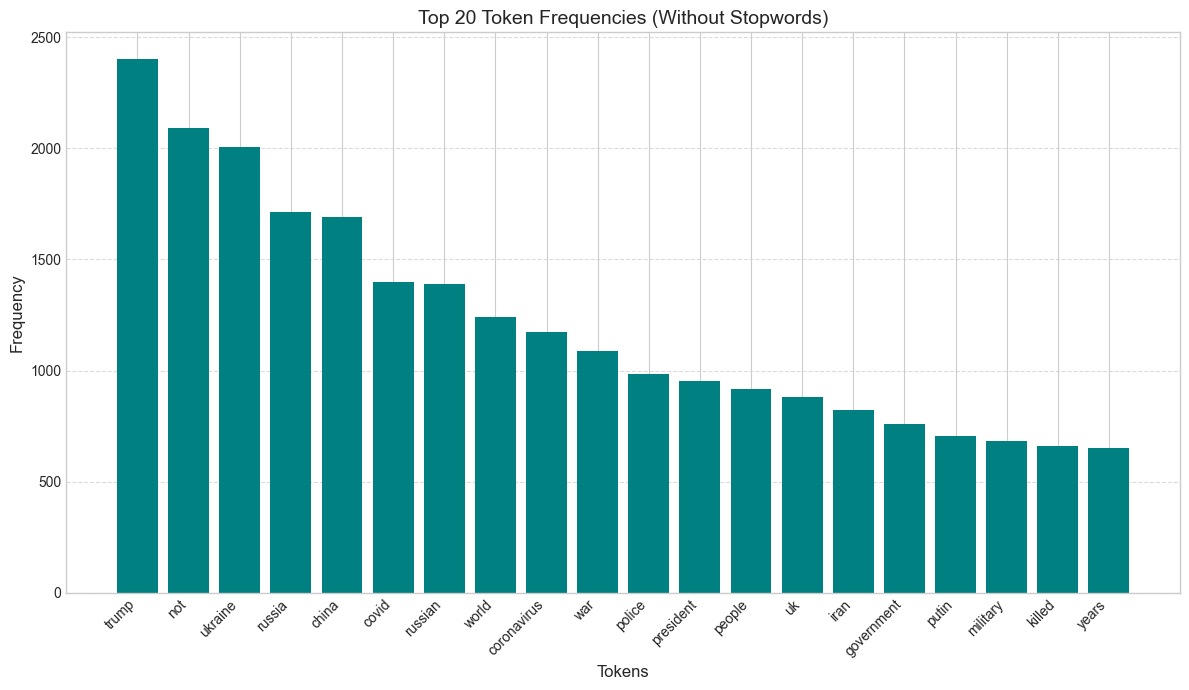


--- TEST CASE ---
After normalization: 'us us trump plan this are not working correctly'
After tokenization: ['us', 'us', 'trump', 'plan', 'this', 'are', 'not', 'working', 'correctly']


In [7]:
from collections import Counter
import matplotlib.pyplot as plt # Import for plotting
import pandas as pd # Assuming news_df is a pandas DataFrame

# --- TOKEN COUNTS & FREQUENCIES ---
print("\n--- TOKEN ANALYSIS ---")

# Calculate counts from the combined list of tokens
# Assuming 'tokens' represents the concatenated tokens for a row
token_count_before = sum(news_df['tokens'].apply(len))
token_count_after = sum(news_df['tokens_nostop'].apply(len))

print("Original total token count:", token_count_before)
print("Total token count after stopword removal:", token_count_after)
print("Reduction: {:.2f}%".format((1 - token_count_after / token_count_before) * 100))

# Display sample for tokens (from the combined list)
print("\nSample before stopword removal (first 20 tokens in the first row):")
# Handle potential empty lists gracefully
print(news_df['tokens'].iloc[0][:20] if news_df['tokens'].iloc[0] else "[]")
print("\nSample after stopword removal (first 20 tokens in the first row):")
# Handle potential empty lists gracefully
print(news_df['tokens_nostop'].iloc[0][:20] if news_df['tokens_nostop'].iloc[0] else "[]")


# Flatten the list of lists of tokens after stopword removal across the entire DataFrame
# This collects *all* non-stopword tokens into a single list for frequency counting
all_tokens_nostop = [token for tokens_list in news_df['tokens_nostop'].tolist() for token in tokens_list]

# Calculate frequency distribution
token_freq = Counter(all_tokens_nostop)

# Print Top N tokens
N = 20
print(f"\n--- TOP {N} TOKENS WITHOUT STOPWORDS ---")
top_tokens = token_freq.most_common(N)
print(top_tokens)

# --- VISUALIZATION ---
print(f"\n--- PLOTTING TOP {N} TOKENS ---")

if top_tokens:
    # Prepare data for plotting
    tokens, counts = zip(*top_tokens)

    plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
    plt.bar(tokens, counts, color='teal') # Using a different color
    plt.xlabel('Tokens', fontsize=12) # Increase font size for labels
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Top {N} Token Frequencies (Without Stopwords)', fontsize=14) # Increase font size for title
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate and adjust alignment of labels
    plt.yticks(fontsize=10) # Increase font size for y-axis ticks
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("No tokens found to plot.")

# --- Test Case (Keep this as it's useful for debugging the initial pipeline steps) ---
print("\n--- TEST CASE ---")
sample_text = "U.S. u.s. Trump's plan This ain't working correctly"
try:
    normalized = normalize_text(sample_text)
    print(f"After normalization: '{normalized}'")
    tokens_sample = tokenize_text(normalized)
    print(f"After tokenization: {tokens_sample}")
except NameError:
    print("Skipping test case: normalize_text or tokenize_text not defined in this scope.")

# **Part of Speech Tagging** 
 Now that we have clean, unified tokens, we can perform Part-of-Speech (POS) tagging. 

 POS tagging assigns a grammatical category (like noun, verb, adjective) to each token.
 
 This is crucial for understanding sentence structure and meaning.


In [8]:
# ================================================================
# FAST, SAFE POS TAGGING
# ================================================================
from itertools import compress
from collections import defaultdict
from tqdm import tqdm

# ------------------------------------------------
# 1)  COMBINED-HEADLINE TOKENS  (tokens_normalized)
# ------------------------------------------------
print("Fast POS tagging – combined headlines …")

# Build list of texts and remember their DataFrame indices
texts_combined      = [" ".join(toks) for toks in news_df['tokens_normalized']]
non_empty_mask      = [bool(txt.strip()) for txt in texts_combined]
texts_non_empty     = list(compress(texts_combined, non_empty_mask))
idx_mapping         = [i for i, keep in enumerate(non_empty_mask) if keep]

# Prepare result container (same length as DataFrame)
pos_tags_combined   = [[] for _ in range(len(news_df))]

# Run spaCy in batches / multi-process
for doc, df_idx in tqdm(
        zip(nlp.pipe(texts_non_empty, batch_size=512, n_process=4),
            idx_mapping),
        total=len(texts_non_empty), 
        desc="combined"):
    
    pos_tags_combined[df_idx] = [(tok.text, tok.pos_) for tok in doc]

news_df['pos_tags_combined'] = pos_tags_combined


# ------------------------------------------------
# 2)  SEPARATE-HEADLINE TOKENS  (separate_tokens_normalized)
# ------------------------------------------------
print("Fast POS tagging – separate headlines …")

texts_sep   = []   # flattened texts to send to spaCy
row_map     = []   # DataFrame row index for each text
sub_map     = []   # sub-list position inside that row

for row_idx, headline_lists in news_df['separate_tokens_normalized'].items():
    for sub_idx, toks in enumerate(headline_lists):
        if toks:                                   # already filtered empties
            texts_sep.append(" ".join(toks))
            row_map.append(row_idx)
            sub_map.append(sub_idx)

# POS-tag all in one go
docs_pos = []
for doc in tqdm(
        nlp.pipe(texts_sep, batch_size=512, n_process=4),
        total=len(texts_sep),
        desc="separate"):
    docs_pos.append([(tok.text, tok.pos_) for tok in doc])

# Re-assemble back into the original nested structure
pos_dict = defaultdict(list)   # row_idx -> list of lists

for row_idx, sub_idx, pos in zip(row_map, sub_map, docs_pos):
    # ensure outer list long enough
    while len(pos_dict[row_idx]) <= sub_idx:
        pos_dict[row_idx].append([])
    pos_dict[row_idx][sub_idx] = pos

news_df['pos_tags_separate'] = news_df.index.map(lambda i: pos_dict.get(i, []))

Fast POS tagging – combined headlines …


combined: 100%|██████████| 1771/1771 [00:23<00:00, 74.41it/s] 


Fast POS tagging – separate headlines …


separate: 100%|██████████| 44073/44073 [00:27<00:00, 1626.07it/s]


# **Lemmatization**

Lemmatization reduces words to their base form (lemma):